Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [37]:
from random import random, seed
from itertools import accumulate
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from collections import deque

from icecream import ic

np.set_printoptions(linewidth=200)

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [38]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [39]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

In [40]:
""" I would like to use the same starting solutions for all algorithms """
starting_solution = rng.random(NUM_SETS) < 0.9

## Helper Functions

In [41]:
def valid(solution: np.ndarray) -> bool:
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution: np.ndarray) -> float:
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

In [42]:
def fitness(solution: np.ndarray) -> float:
    """Returns the fitness of a solution as just the negative of cost"""
    return (valid(solution), -cost(solution))

In [43]:
def tweak__single(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol
    

In [44]:
def tweak__single_or_double(solution: np.ndarray, mutation_prob: float) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(NUM_SETS)
    new_sol[i] = not new_sol[i]
    
    if rng.random() < mutation_prob:
        j = rng.integers(NUM_SETS)
        new_sol[j] = not new_sol[j]
    
    return new_sol
    

In [45]:
def tweak__multiple(solution: np.ndarray, strength: float) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True

    new_sol = np.logical_xor(solution, mask)
    return new_sol

# Introduction
The following file aims to describe the contents of "set-cover.ipynb" and its "findings". 

The solution of the set-cover problem utilized the provided cost and validation functions, while for the fitness, it uses a solution proposed in class, which is tuple containing validity and cost * -1.    

The outputs provided are relative to a problem enunciation with small numbers, as my computer is not able to compute the biggest proposed setting in less than 5 hours. The values are as follows
```
UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.2

NOF_ITERATIONS = 10_000
```

The various approaches lead to different results, of which brief analyses will be provided (for the graphs and data please refer to the pdf version of the notebook).

(Note that for the simplest possible problem, the better approach logically is the tabu one, which is not taclked in the following file)

# Approaches

### Single Tweak HC
The first approach uses as tweak a simple one bit flip.  
The final fitness sits at around -130k, which as we will see, is already quite a good result.  


ic| fitness(solution): (np.True_, np.float64(-137469.4255128316))


Text(0.95, 0.1, 'Current Fitness: (np.True_, np.float64(-137469.4255128316))')

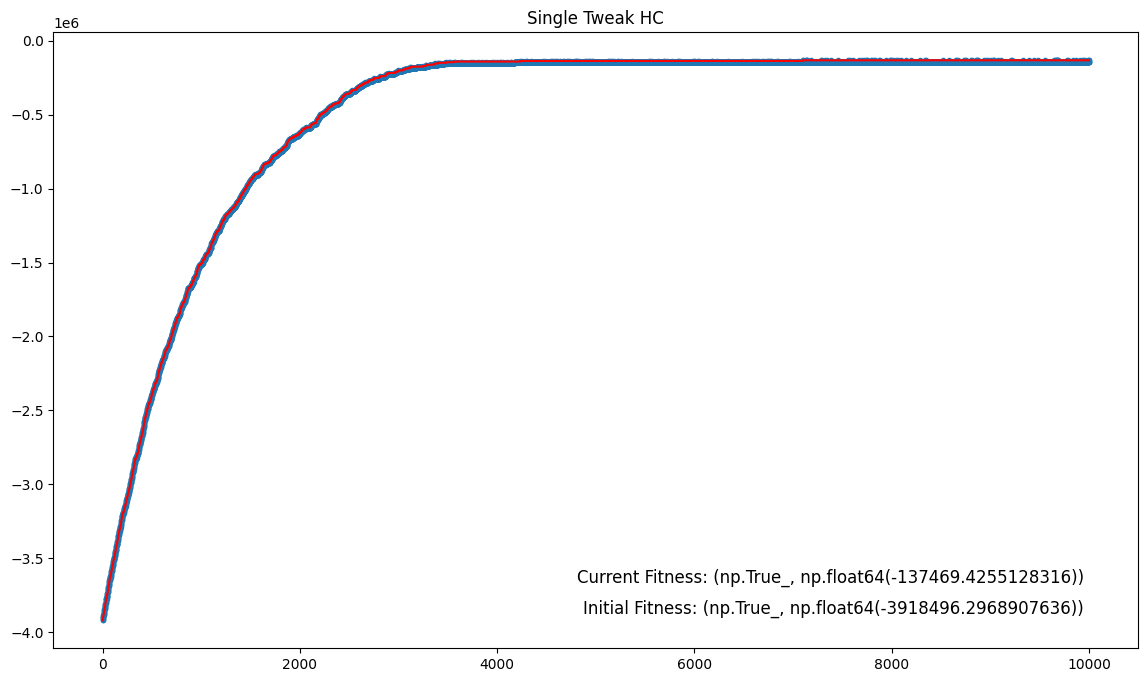

In [49]:
""" Computing the solution """
solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
history = [cur_fitness[1]]

for steps in range(10_000):
    new_solution = tweak__single(solution)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness

ic(fitness(solution))

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )          
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks
plt.title("Single Tweak HC")
plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


### Single/Double Tweak HC (30% and 5%)
This is just a variation of the previous approach, which merely adds a possible second bit flip with a probability of 30% at each iteration for the first version and 5% for the second.  
The final fitness sits around -130k again. If there actually is an improvement, it's quite slight. 

ic| fitness(solution): (np.True_, np.float64(-3918496.2968907636))
ic| fitness(solution): (np.True_, np.float64(-122179.97327626811))
ic| fitness(solution): (np.True_, np.float64(-3918496.2968907636))
ic| fitness(solution): (np.True_, np.float64(-136330.14852920017))


Text(0.95, 0.1, 'Current Fitness: (np.True_, np.float64(-136330.14852920017))')

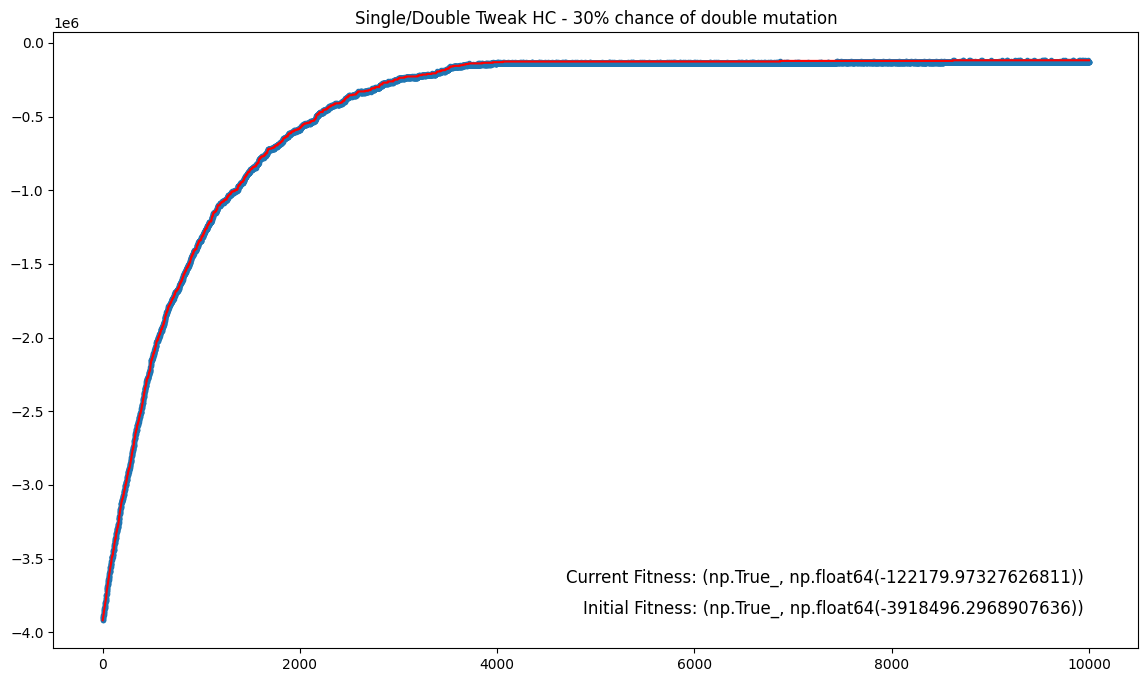

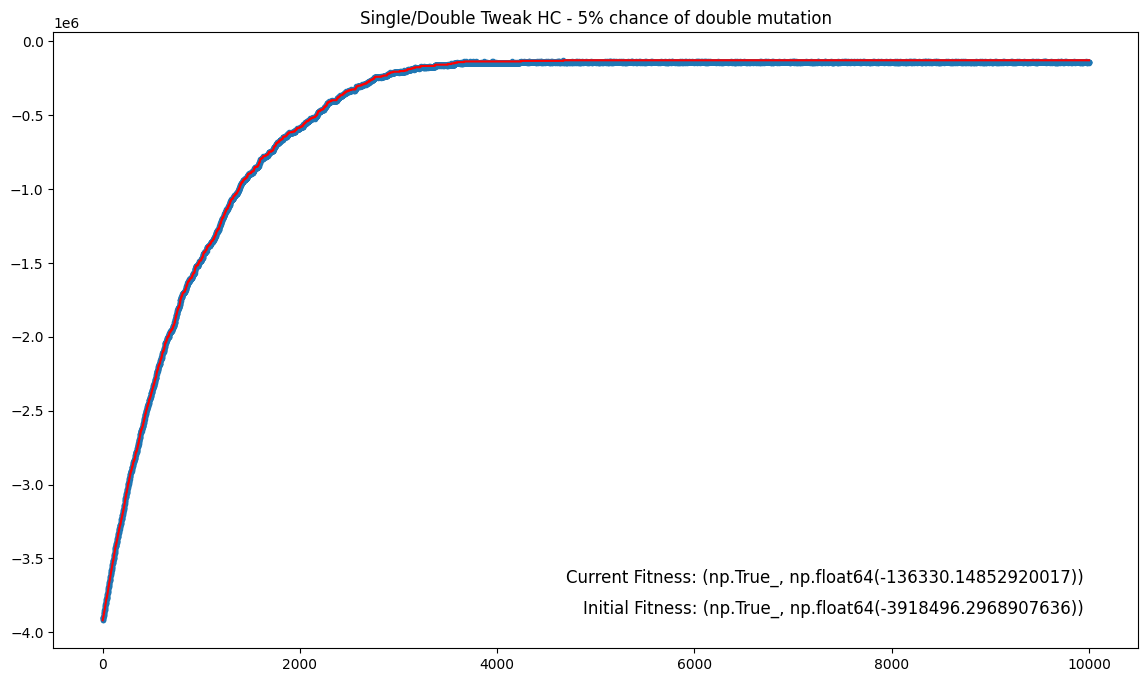

In [50]:
""" Computing the solution with more chance for double mutation """
solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    new_solution = tweak__single_or_double(solution, 0.3)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness

ic(fitness(solution))

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.title("Single/Double Tweak HC - 30% chance of double mutation")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


""" ========================================================================================================================== """
""" Computing the solution with less chance for double mutation """
solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    new_solution = tweak__single_or_double(solution, 0.05)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness

ic(fitness(solution))

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.title("Single/Double Tweak HC - 5% chance of double mutation")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


### Multiple Tweak HC
This approach uses multiple bit flips, with a flip density of 30% for the first version, 1% for the second, and 0.5% for the last.  
Going only for exploration definitely worsens the results.  

ic| fitness(solution): (np.True_, np.float64(-3918496.2968907636))
ic| fitness(solution): (np.True_, np.float64(-1744798.5814885637))
ic| fitness(solution): (np.True_, np.float64(-3918496.2968907636))
ic| fitness(solution): (np.True_, np.float64(-524046.7637432331))
ic| fitness(solution): (np.True_, np.float64(-3918496.2968907636))
ic| fitness(solution): (np.True_, np.float64(-294732.3117952929))


Text(0.95, 0.1, 'Current Fitness: (np.True_, np.float64(-294732.3117952929))')

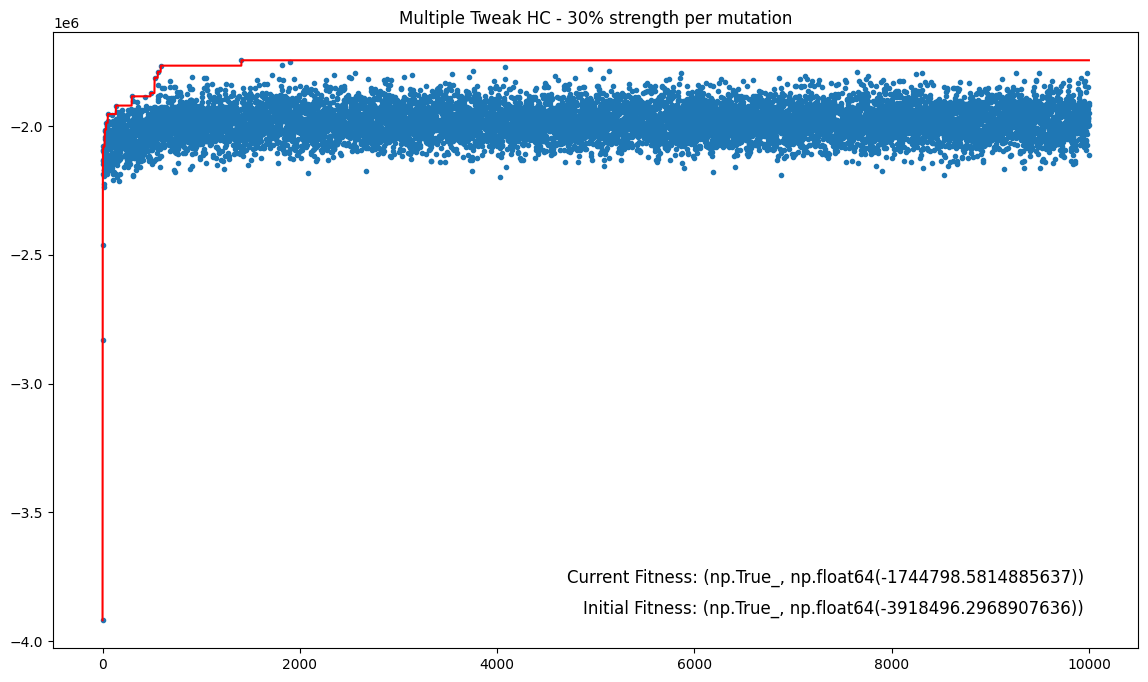

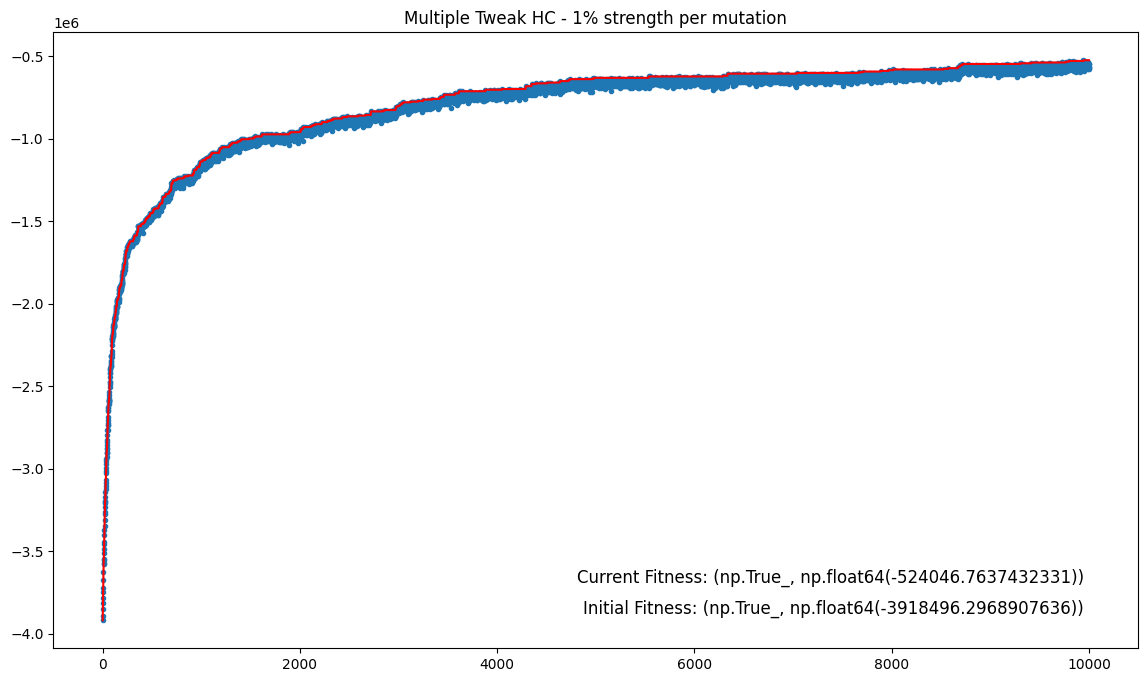

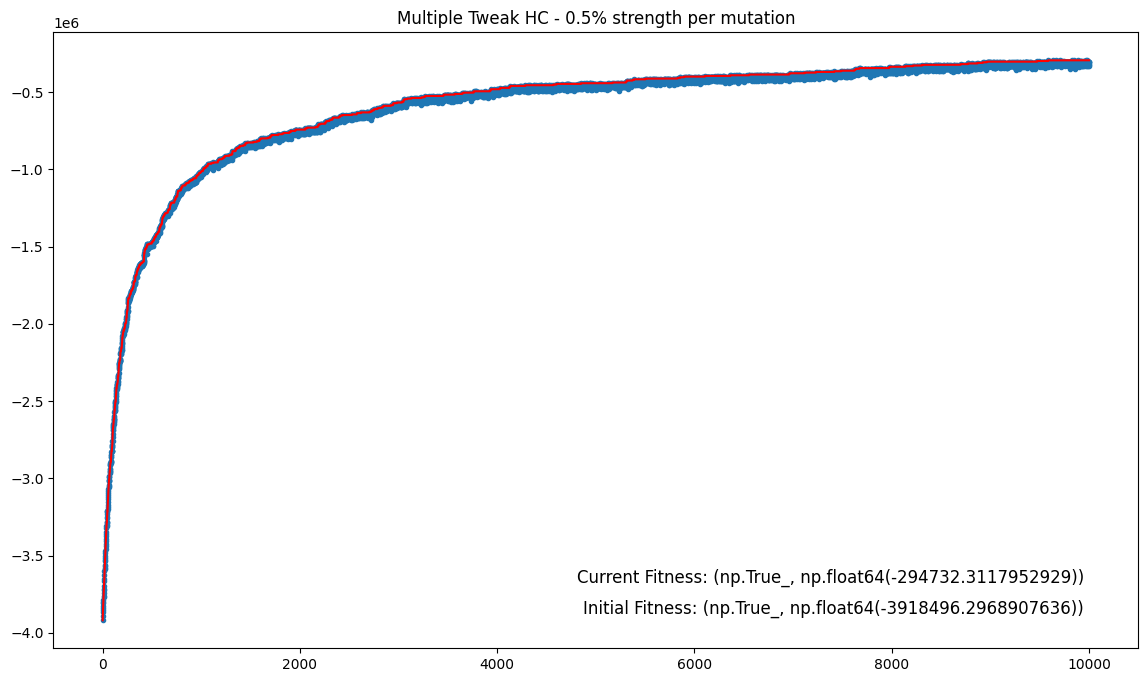

In [51]:
""" Computing the solution with high exploration """
solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    new_solution = tweak__multiple(solution, 0.3)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness

ic(fitness(solution))

""" Plotting the solution """
plt.figure(figsize=(14, 8))
plt.title("Multiple Tweak HC - 30% strength per mutation")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


""" ============================================================================================================ """
""" Computing the solution with lower exploration """
solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    new_solution = tweak__multiple(solution, 0.01)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness

ic(fitness(solution))

""" Plotting the solution """
plt.figure(figsize=(14, 8))
plt.title("Multiple Tweak HC - 1% strength per mutation")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

""" ============================================================================================================ """
""" Computing the solution with EVEN lower exploration """
solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    new_solution = tweak__multiple(solution, 0.005)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness

ic(fitness(solution))

""" Plotting the solution """
plt.figure(figsize=(14, 8))
plt.title("Multiple Tweak HC - 0.5% strength per mutation")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


### HC - Exploration/Exploitation Through Strength Update For Multiple Tweak Following rule-of-5
Here we are allowing for sometimes changing the step of the exploration using the rule-of-5, meaning that we use a multiple tweak with variable strength.
We use a buffer for the rule-of-5 with 35 slots, while the strength starts at 0.01 and with a multiplier of 1.2.
The fitness is around the -130k meark, and the exploration only seesm to be effective in the very first iterations.  

ic| fitness(solution): (np.True_, np.float64(-3918496.2968907636))
ic| fitness(solution): (np.True_, np.float64(-123891.66532562251))


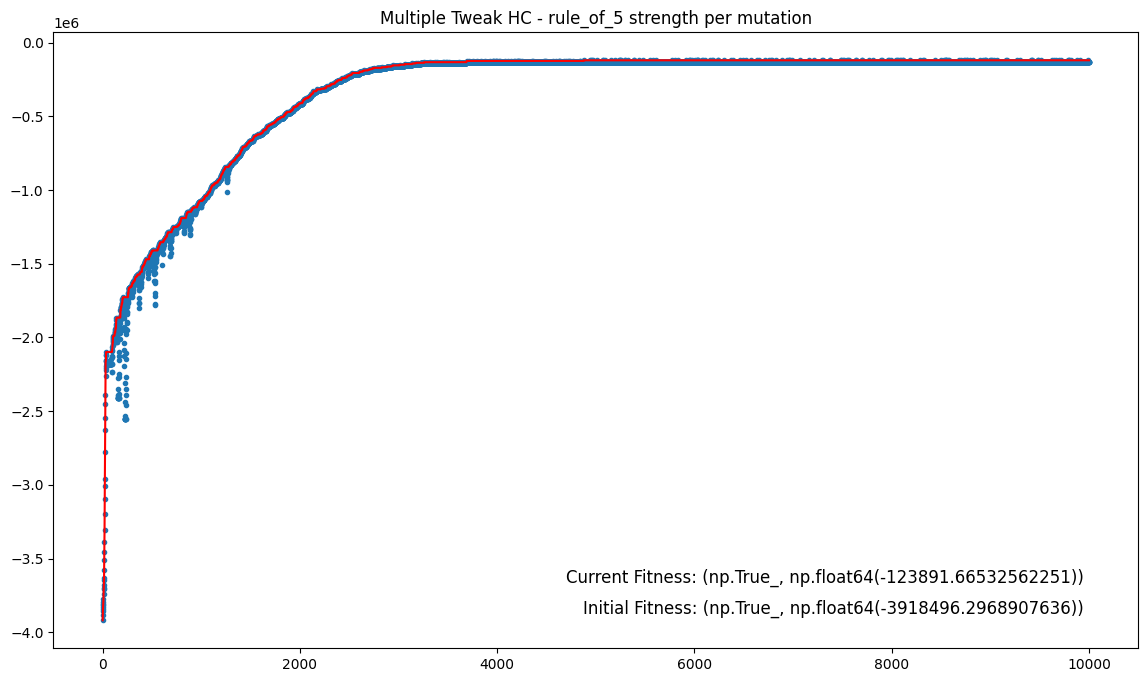

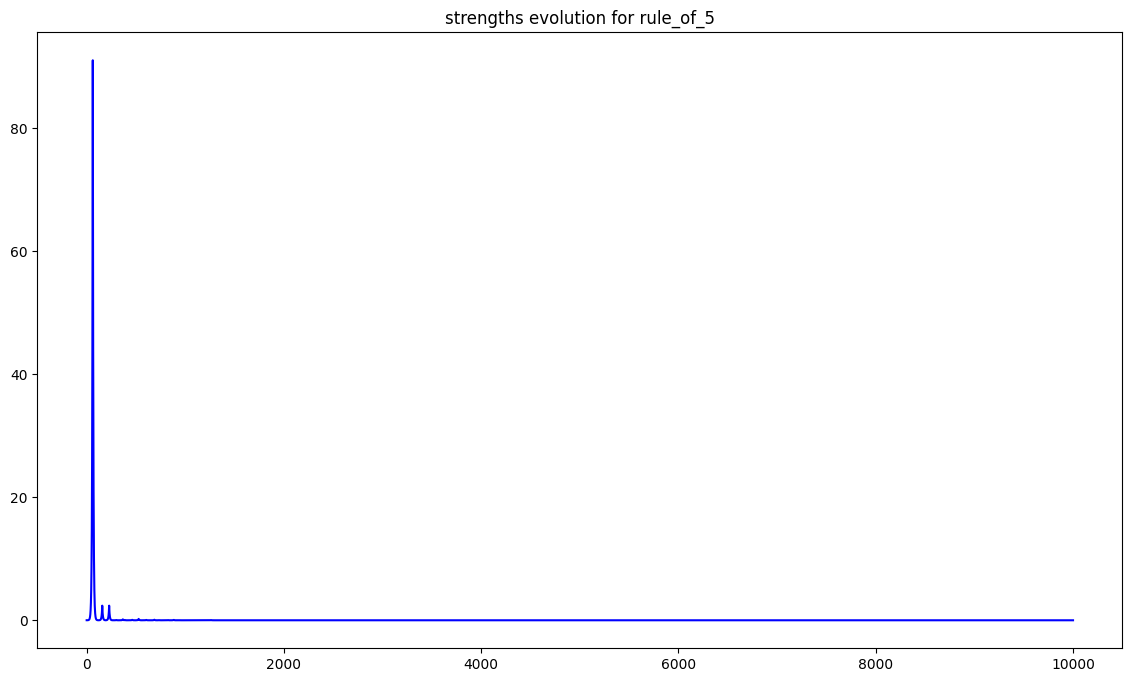

In [52]:
""" ============================================================================================================ """
""" Computing the solution with rule of 5 for tweak strength """
BUFFER_SIZE = 35 # keep it a multiple of 5
buffer = deque(maxlen=BUFFER_SIZE)

solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

strength = 0.01
strength_multiplier = 1.2
strengths = [strength]
for steps in range(10_000):
    new_solution = tweak__multiple(solution, strength)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    buffer.append(new_fitness > cur_fitness)
    if sum(buffer) >= BUFFER_SIZE / 5:
        strength *= strength_multiplier
    elif sum(buffer) < BUFFER_SIZE / 5:
        strength /= strength_multiplier
    strengths.append(strength)

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness    

ic(fitness(solution))

""" Plotting the solution """
plt.figure(figsize=(14, 8))
plt.title("Multiple Tweak HC - rule_of_5 strength per mutation")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )

_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks
plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


""" Plotting the strengths """
plt.figure(figsize=(14, 8))
plt.title("strengths evolution for rule_of_5")
plt.plot(range(len(strengths)), strengths, color="blue")

### HC - Eploration/Exploitation Through Probability Of Taking Random Jumps
In this variant we allow for a random chance to teleport the solution to some distant position. When doing normal steps we use just a single tweak, while for the random jumps, we use a multiple tweak with a strength of 1%.  
In the first version we use a 30% chance of jumping at each iteration, and just 1% in the second one.  
When the jump chance is too high the results aren't good (although not tragically worse), while in the 1% case we stay on the -130k line.  

ic| fitness(solution):

 (np.True_, np.float64(-3918496.2968907636))
ic| fitness(best_solution_ever): (np.True_, np.float64(-200670.34916975646))
ic| fitness(solution): (np.True_, np.float64(-3918496.2968907636))
ic| fitness(best_solution_ever): (np.True_, np.float64(-132378.19165307345))


Text(0.95, 0.1, 'Current Fitness: (np.True_, np.float64(-132378.19165307345))')

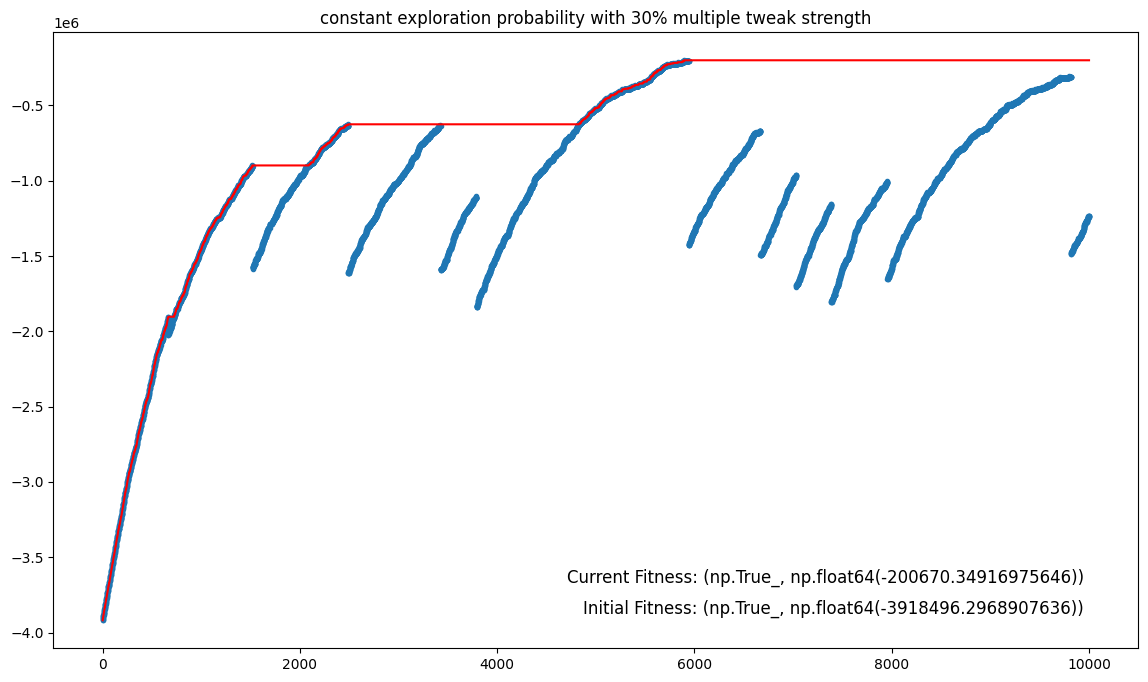

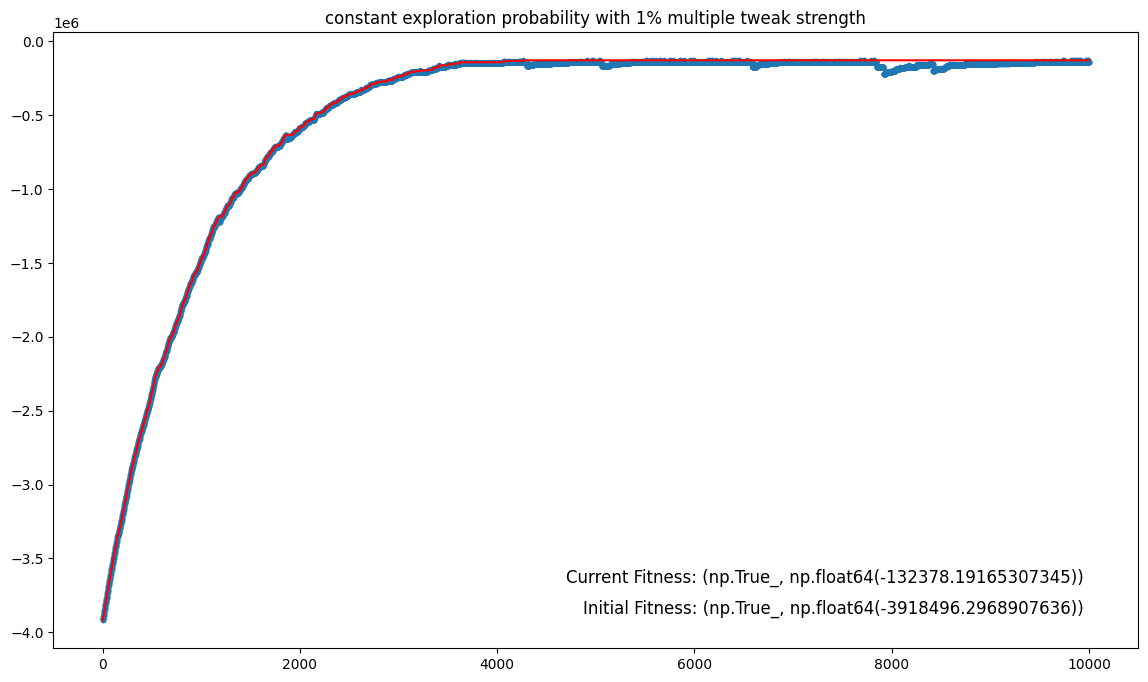

In [53]:
""" Computing the solution with more exploration """
solution = starting_solution
best_solution_ever = solution # This is needed because we allow for worse solutions to be accepted
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    if rng.random() < 0.001:
        new_solution = tweak__multiple(solution, 0.3)
        new_fitness = fitness(new_solution)
        history.append(new_fitness[1])

        solution = new_solution
        cur_fitness = new_fitness
    else:
        new_solution = tweak__single(solution)
        new_fitness = fitness(new_solution)
        history.append(new_fitness[1])

        if new_fitness > cur_fitness:
            solution = new_solution
            cur_fitness = new_fitness
    
    if cur_fitness > fitness(best_solution_ever):
        best_solution_ever = solution
        

ic(fitness(best_solution_ever))

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.title("constant exploration probability with 30% multiple tweak strength")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {fitness(best_solution_ever)}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


""" ============================================================================================================ """
""" Computing the solution with less exploration """
solution = starting_solution
best_solution_ever = solution # This is needed because we allow for worse solutions to be accepted
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    if rng.random() < 0.001:
        new_solution = tweak__multiple(solution, 0.01)
        new_fitness = fitness(new_solution)
        history.append(new_fitness[1])

        solution = new_solution
        cur_fitness = new_fitness
    else:
        new_solution = tweak__single(solution)
        new_fitness = fitness(new_solution)
        history.append(new_fitness[1])

        if new_fitness > cur_fitness:
            solution = new_solution
            cur_fitness = new_fitness

    if cur_fitness > fitness(best_solution_ever):
        best_solution_ever = solution
        

ic(fitness(best_solution_ever))

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.title("constant exploration probability with 1% multiple tweak strength")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {fitness(best_solution_ever)}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


### Single/Double HC - Simulated Annealing
In this final approach I tried implementing simulated annealing. I'm not confident I implemented a good version of it, but the results seems to be on par with the other aproaches.  
I tried different approaches for the temperature, by first setting it constant, and then decreasing it by some amount every 100 iterations.  
As already stated, the results are pretty much the same as before - although it seems like, with different tries, that simulated annealing with constant temperature keeps more consistent low values (e.g. doesn't seem to go below -125k).

ic| fitness(solution): (np.

True_, np.float64(-3918496.2968907636))
ic| temperature: np.float64(1.778279410038923), step_temperature: 0.01
ic| best_fitness_ever: (np.True_, np.float64(-122431.71722969359))


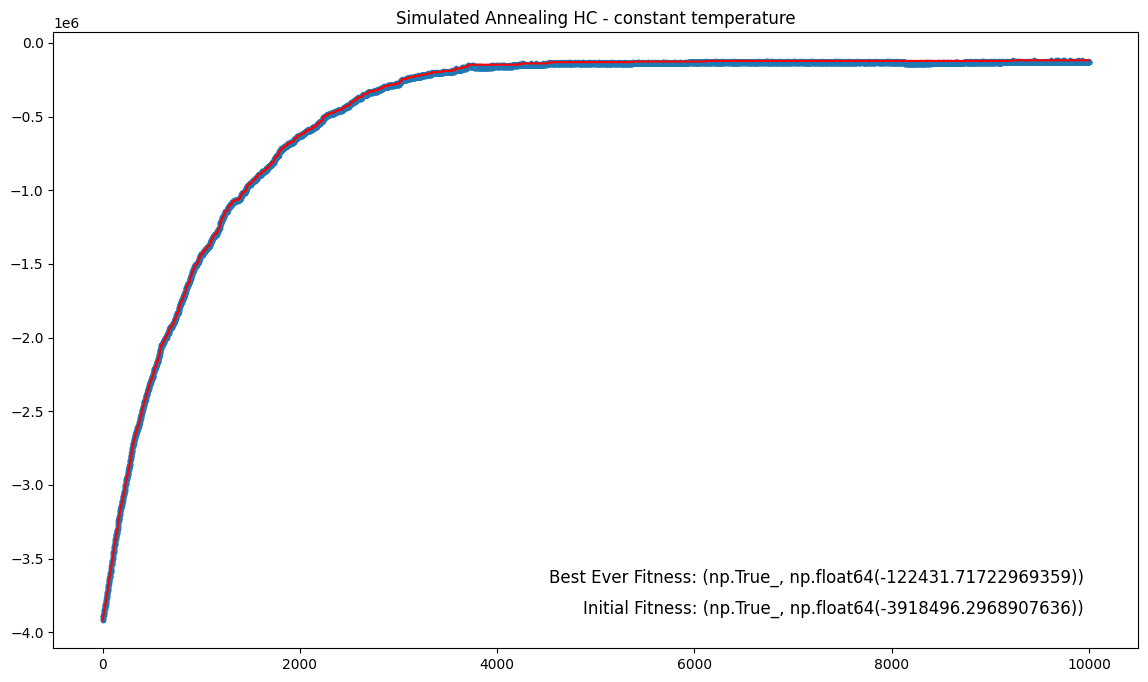

ic| fitness(solution): (np.True_, np.float64(-3918496.2968907636))
ic| temperature: np.float64(1.778279410038923), step_temperature: 0.01
ic| best_fitness_ever: (np.True_, np.float64(-126440.39165107688))


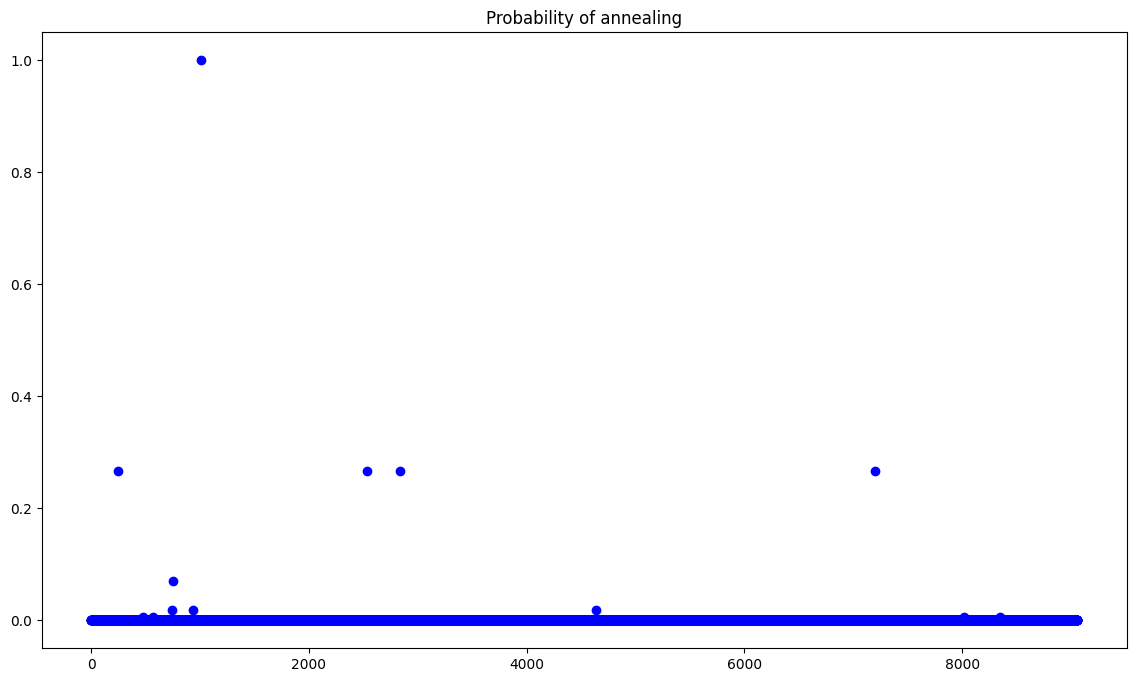

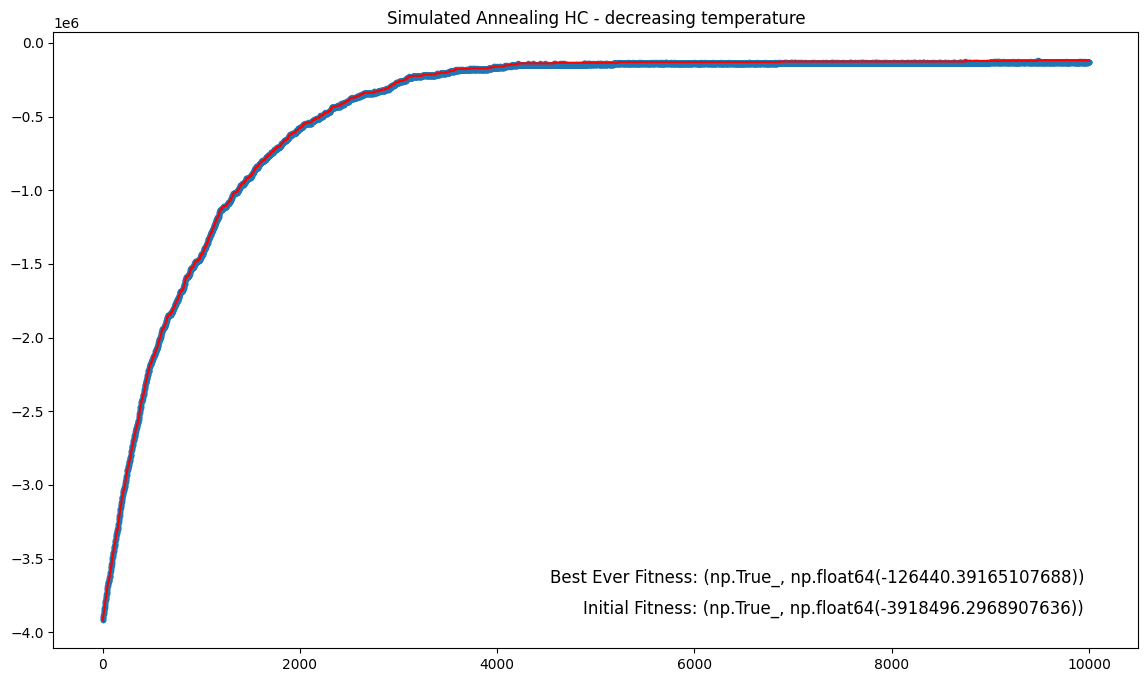

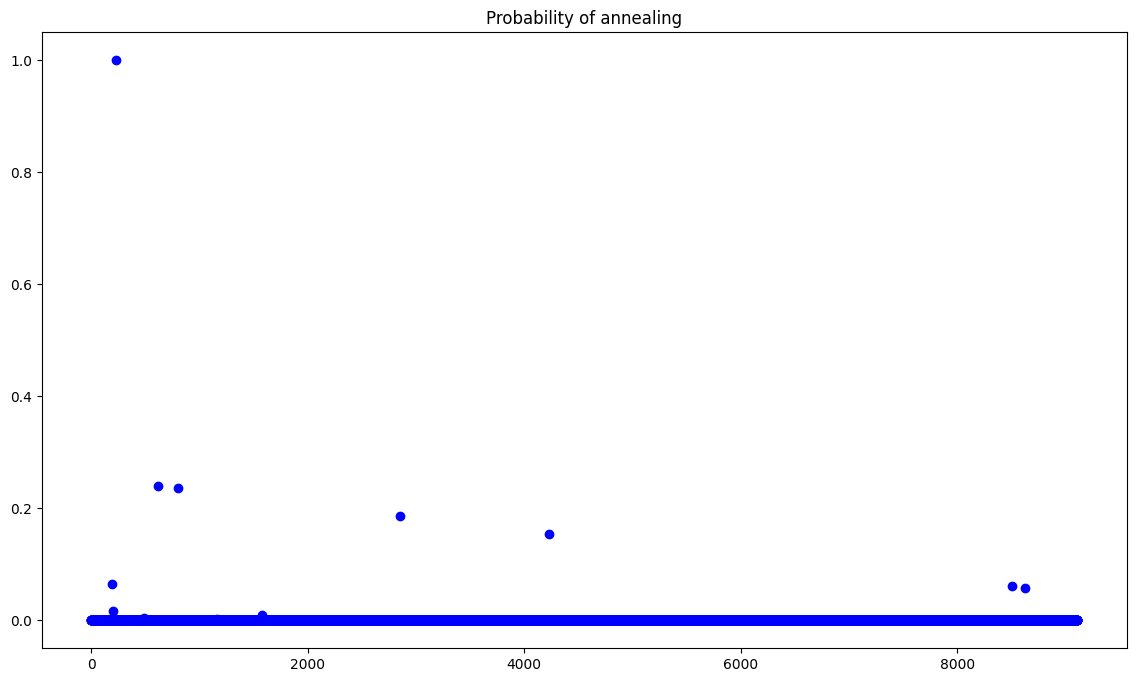

In [54]:
""" Computing the solution with constant temperature """
solution = starting_solution
best_solution_ever = solution  # This is needed because we allow for worse solutions to be accepted
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness]
ps = []
difs = []

temperature = np.exp(np.log(UNIVERSE_SIZE) / 16)
step_temperature = 0.01
ic(temperature, step_temperature)

for steps in range(10_000):
    new_solution = tweak__single_or_double(solution, 0.3)
    new_fitness = fitness(new_solution)
    history.append(new_fitness)

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness
    elif new_fitness == cur_fitness:
        continue
    else:
        p = np.exp(-(np.abs(cur_fitness[1] - new_fitness[1])) / temperature)
        ps.append(p)
        difs.append(np.abs(cur_fitness[1] - new_fitness[1]))

        if rng.random() < p:
            solution = new_solution
            cur_fitness = new_fitness

    if cur_fitness > fitness(best_solution_ever):
        best_solution_ever = solution

best_fitness_ever = fitness(best_solution_ever)
ic(best_fitness_ever)

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.title("Simulated Annealing HC - constant temperature")
plt.plot(
    range(len(history)),  # Growth-only Tweaks
    list(accumulate([f[1] for f in history], max)),
    color="red"
)
_ = plt.scatter(range(len(history)), [f[1] for f in history], marker=".")  # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Best Ever Fitness: {best_fitness_ever}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

plt.show()

""" Plotting the probabilities of annealing """
plt.figure(figsize=(14, 8))
plt.title("Probability of annealing")
plt.scatter(
    range(len(ps)),
    ps,  # probability of accepting worse solution
    color="blue"
)
# plt.scatter(   range(len(difs)),
#             difs,
#             color="yellow"
#             )

""" ========================================================================================================================== """
""" Computing the solution with temperature descent """
solution = starting_solution
best_solution_ever = solution  # This is needed because we allow for worse solutions to be accepted
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness]
ps = []
difs = []

temperature = np.exp(np.log(UNIVERSE_SIZE) / 16)
step_temperature = 0.01
ic(temperature, step_temperature)

for steps in range(10_000):
    new_solution = tweak__single_or_double(solution, 0.3)
    new_fitness = fitness(new_solution)
    history.append(new_fitness)

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness
    elif new_fitness == cur_fitness:
        continue
    else:
        p = np.exp(-(np.abs(cur_fitness[1] - new_fitness[1])) / temperature)
        ps.append(p)
        difs.append(np.abs(cur_fitness[1] - new_fitness[1]))

        if rng.random() < p:
            solution = new_solution
            cur_fitness = new_fitness

    if cur_fitness > fitness(best_solution_ever):
        best_solution_ever = solution

    if steps % 100 == 0:
        temperature -= step_temperature if temperature > 0 else step_temperature

best_fitness_ever = fitness(best_solution_ever)
ic(best_fitness_ever)

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.title("Simulated Annealing HC - decreasing temperature")
plt.plot(
    range(len(history)),  # Growth-only Tweaks
    list(accumulate([f[1] for f in history], max)),
    color="red"
)
_ = plt.scatter(range(len(history)), [f[1] for f in history], marker=".")  # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Best Ever Fitness: {best_fitness_ever}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

plt.show()

""" Plotting the probabilities of annealing """
plt.figure(figsize=(14, 8))
plt.title("Probability of annealing")
plt.scatter(
    range(len(ps)),
    ps,  # probability of accepting worse solution
    color="blue"
)
# plt.scatter(   range(len(difs)),
#             difs,
#             color="yellow"
#             )

# Conclusion
Utilizing restarts or annealings or doing lots of eploration doesn't yield results that are noticeably better than more linear ones, which may suggest that the landscape's optima aren't all that different from one another (assuing we haven't missed some extremely good optima). 